# Imports

In [2]:
import pandas as pd
import numpy as np
from pycirclize import Circos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Smetana

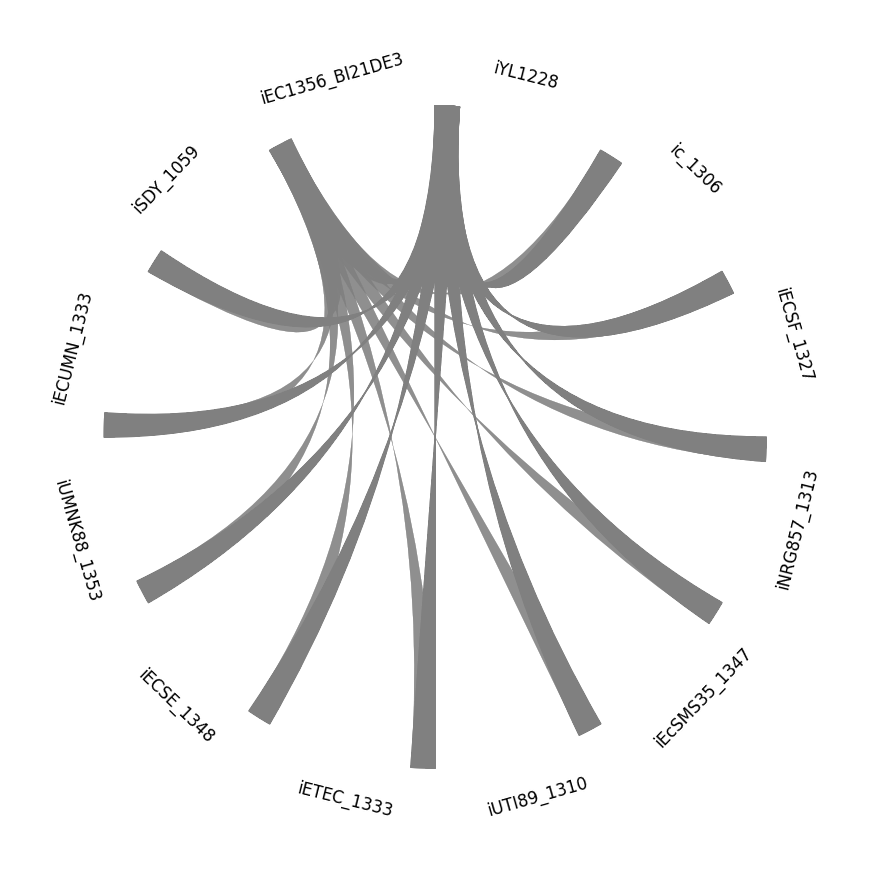

In [3]:
# Load SMETANA detailed-mode TSV file
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/smetana_all_detailed.tsv", sep="\t")

# Count interactions per strain to define sector size
strain_counts = pd.concat([df["donor"], df["receiver"]]).value_counts()
sectors = {strain: max(5, min(20, count)) for strain, count in strain_counts.items()}

# Create Circos object
circos = Circos(sectors, space=2)

# Add sector labels
for sector in circos.sectors:
    sector.text(sector.name, r=110, size=12)

# Add links based on donor-receiver interactions
for _, row in df.iterrows():
    donor = row["donor"]
    receiver = row["receiver"]
    score = row["smetana"]
    if donor in sectors and receiver in sectors:
        circos.link(
            (donor, 0, 3),
            (receiver, 0, 3),
            lw=score, color="gray"
        )

# Show circos plot
fig = circos.plotfig()
plt.show()


# Micom

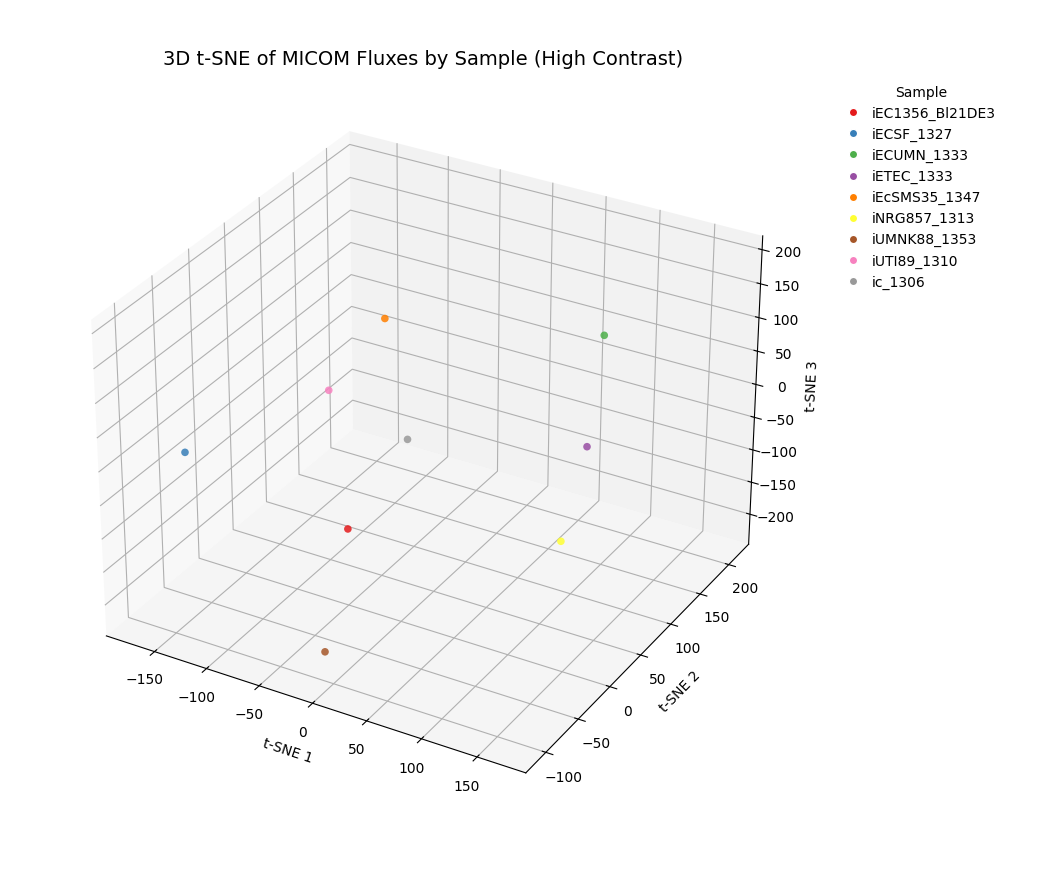

In [87]:
# Load dataset with row names as sample labels
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/fluxes_MICOM.csv", sep=";", index_col=0)

# Sample labels from row index
sample_labels = df.index.to_list()

# Keep only numeric flux columns (reactions)
flux_data = df.select_dtypes(include=["float64", "int64"])

# Replace NaNs with 0.0
flux_data_filled = flux_data.fillna(0.0)

# Filter reactions with total flux > threshold across strains
threshold = 1e-6
mask = flux_data_filled.abs().sum(axis=0) > threshold
filtered_fluxes = flux_data_filled.T[mask].T

# Standardize
X_scaled = StandardScaler().fit_transform(filtered_fluxes)

# PCA
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
X_pca = PCA(n_components=n_components).fit_transform(X_scaled)

# t-SNE in 3D
X_tsne = TSNE(n_components=3, perplexity=min(X_scaled.shape[0], X_scaled.shape[1]) - 1, random_state=42).fit_transform(X_pca)

# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(sample_labels)

# Use strong contrast colormap
colormap = 'Set1'  # alternatives: 'tab10', 'Dark2'

# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c=encoded_labels, cmap=colormap, s=30, alpha=0.85)

ax.set_title("3D t-SNE of MICOM Fluxes by Sample (High Contrast)", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")

# Legend
legend_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                             label=lbl, markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=6)
                  for i, lbl in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [75]:
X_pca

array([[-1.05401790e+01,  5.68729674e+00, -2.54659693e+01,
        -1.79583756e+00,  9.46773420e-02, -3.39655057e-01,
        -2.67437982e-02,  9.80535235e-02,  2.71383301e-15],
       [-1.35691818e+00, -1.11318204e+01,  1.32001394e+00,
        -1.67228798e+00, -1.06176894e+00,  4.77203132e+00,
        -1.52862816e+00,  1.49580304e+00,  2.71383301e-15],
       [ 1.18020022e+01, -1.20259641e+01, -2.09031538e+00,
         9.91791809e+00,  6.47970268e+00, -6.12627193e-01,
         1.01636826e-01, -3.46560965e-01,  2.71383301e-15],
       [-3.90656304e+00, -8.35383014e+00,  5.79425633e+00,
        -8.07992174e+00,  6.00023873e+00, -2.92862374e+00,
        -1.09435467e+00,  7.21892376e-01,  2.71383301e-15],
       [ 5.15530796e+01,  1.13135514e+01,  1.08958513e+00,
        -1.92741289e+00, -1.86622381e+00, -3.82406092e-02,
         8.78225086e-02,  1.64154682e-02,  2.71383301e-15],
       [-6.29137240e+00, -7.51857843e+00,  2.65770478e+00,
        -1.90270704e+00, -4.06871730e+00,  3.219708

In [76]:
X_tsne

array([[  15.649049 , -100.752525 ,   -7.65893  ],
       [-172.0765   ,  -48.88868  ,  -29.227661 ],
       [  64.142395 ,  212.11246  ,   36.339012 ],
       [ 168.4357   ,   -0.7638586,   95.84428  ],
       [ -64.82294  ,   80.6678   ,  110.786415 ],
       [ 122.65828  ,   42.521873 , -102.8164   ],
       [ -15.157605 ,  -88.59756  , -217.50116  ],
       [   4.1443067, -106.988754 ,  190.3021   ],
       [ -68.5631   ,  120.12545  , -106.27947  ]], dtype=float32)

# SteadyComm